# Deviation of Results from the Expectations

This document shows how much the results of the preliminary minitest (PM) deviate from the expectations marked by the IRT analysis, and especially how much the results of the final minitest (PM) deviate from the expectations marked by the IRT 

## Analysis question by question

 question  expected_total  std_dev  z_score_min  z_score_max  obs_total_pm  obs_total_fm  z_score_pm  z_score_fm  delta_z_score  IRT-PM_deviation  IRT-FM_deviation  PM-FM_deviation  p_value_pm  p_value_fm
        1          16.741 3.117969    -5.369201     7.459664            28            37    3.611005    6.497499       2.886495          0.484071          0.871018         0.386947      0.0004         0.0
        2          17.332 3.130433    -5.536615     7.241172            25            38    2.449502    6.602282       4.152781          0.338274          0.911770         0.573496      0.0114         0.0
        3          21.331 3.143980    -6.784712     5.938015            20             6   -0.423349   -4.876303      -4.452954          0.062397          0.718719         0.656322      0.3896         0.0
        4          16.009 3.098578    -5.166564     7.742585            17            39    0.319824    7.419856       7.100032          0.041307          0.958318         0.917011

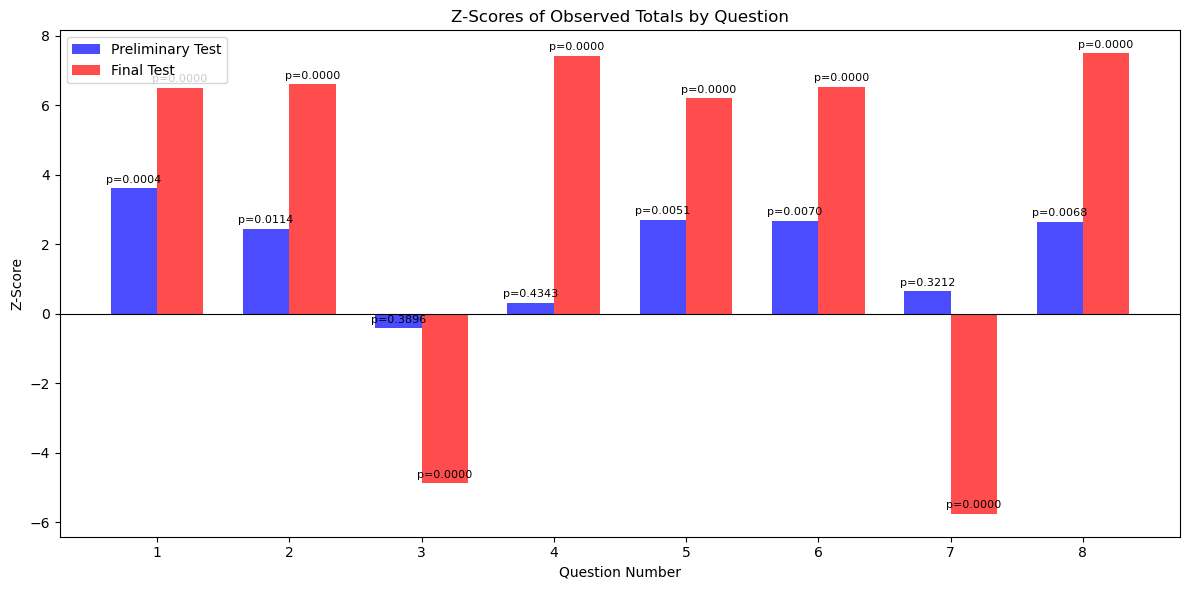

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Initialize lists to store results
results_per_question = []

def analyze_question(questionNum):
    # Get question label
    question = f'Q{questionNum}'

    # Extract probabilities for the question
    probs = data[f'{question}_prob'].values

    # Extract observed responses for preliminary and final minitests
    obs_pm = data[f'{question}_pm'].values.astype(int)
    obs_fm = data[question].values.astype(int)
    n_students = len(probs)

    # Expected total correct responses
    expected_total = probs.sum()

    # Variance and standard deviation
    variances = probs * (1 - probs)
    total_variance = variances.sum()
    std_dev = np.sqrt(total_variance)

    # Z-Score minimum and maximum
    # When all answers are wrong, z_score_min is computed as:
    z_score_min = (0 - expected_total) / std_dev
    # When all answers are correct, z_score_max is computed as:
    z_score_max = (n_students - expected_total) / std_dev

    # Observed total correct responses
    obs_total_pm = obs_pm.sum()
    obs_total_fm = obs_fm.sum()

    # Simulation for p-value
    n_simulations = 10000
    sim_totals = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_totals.append(sim_responses.sum())
    sim_totals = np.array(sim_totals)

    # P-value for preliminary minitest
    p_value_pm = np.mean(sim_totals >= obs_total_pm) if obs_total_pm >= expected_total else np.mean(sim_totals <= obs_total_pm)

    # P-value for final minitest
    p_value_fm = np.mean(sim_totals >= obs_total_fm) if obs_total_fm >= expected_total else np.mean(sim_totals <= obs_total_fm)

    # Calculate z-scores
    z_score_pm = (obs_total_pm - expected_total) / std_dev
    z_score_fm = (obs_total_fm - expected_total) / std_dev

    # Calculate change in z-scores (not absolute value)
    delta_z_score = z_score_fm - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation = z_score_fm / z_score_min if z_score_fm < 0 else z_score_fm / z_score_max
    PM_FM_deviation = delta_z_score / z_score_min if delta_z_score < 0 else delta_z_score / z_score_max

    # Store data for visualization
    results = {
        'question': questionNum,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'obs_total_pm': obs_total_pm,
        'obs_total_fm': obs_total_fm,
        'z_score_pm': z_score_pm,
        'z_score_fm': z_score_fm,
        'delta_z_score': delta_z_score,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation': IRT_FM_deviation,
        'PM-FM_deviation': PM_FM_deviation,
        'p_value_pm': p_value_pm,  # Include p_value_pm in the dictionary
        'p_value_fm': p_value_fm   # Include p_value_fm in the dictionary
    }

    return results

# Analyze each question and collect results
for q_num in range(1, 9):
    result = analyze_question(q_num)
    results_per_question.append(result)

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results_per_question)

# Display the results in the desired format
print(results_df.to_string(index=False))

# Extract z-scores and question numbers for plotting
questions = results_df['question']
z_scores_pm = results_df['z_score_pm']
z_scores_fm = results_df['z_score_fm']

# Plotting z-scores
bar_width = 0.35
index = np.arange(len(questions))

plt.figure(figsize=(12, 6))
plt.bar(index, z_scores_pm, bar_width, label='Preliminary Test', alpha=0.7, color='blue')
plt.bar(index + bar_width, z_scores_fm, bar_width, label='Final Test', alpha=0.7, color='red')

plt.xlabel('Question Number')
plt.ylabel('Z-Score')
plt.title('Z-Scores of Observed Totals by Question')
plt.xticks(index + bar_width / 2, questions)
plt.axhline(0, color='black', linewidth=0.8)

# Adding p-values as text on top of each bar
for i, (z_pm, z_fm, q_num) in enumerate(zip(z_scores_pm, z_scores_fm, questions)):
    # Check if 'p_value_pm' and 'p_value_fm' columns exist before accessing them
    if 'p_value_pm' in results_df.columns and 'p_value_fm' in results_df.columns:
        p_value_pm = results_df.iloc[i]['p_value_pm']
        p_value_fm = results_df.iloc[i]['p_value_fm']
        plt.text(i, z_pm + 0.1, f'p={p_value_pm:.4f}', ha='center', va='bottom', fontsize=8, color='black')
        plt.text(i + bar_width, z_fm + 0.1, f'p={p_value_fm:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.legend()
plt.tight_layout()
plt.show()


##### In the version below, the plot changes from zScores to deviation rate.

 question  expected_total  std_dev  z_score_min  z_score_max  obs_total_pm  obs_total_fm  z_score_pm  z_score_fm  delta_z_score  IRT-PM_deviation  IRT-FM_deviation  PM-FM_deviation  p_value_pm  p_value_fm
        1          16.741 3.117969    -5.369201     7.459664            28            37    3.611005    6.497499       2.886495          0.484071          0.871018         0.386947      0.0001         0.0
        2          17.332 3.130433    -5.536615     7.241172            25            38    2.449502    6.602282       4.152781          0.338274          0.911770         0.573496      0.0095         0.0
        3          21.331 3.143980    -6.784712     5.938015            20             6   -0.423349   -4.876303      -4.452954          0.062397          0.718719         0.656322      0.3954         0.0
        4          16.009 3.098578    -5.166564     7.742585            17            39    0.319824    7.419856       7.100032          0.041307          0.958318         0.917011

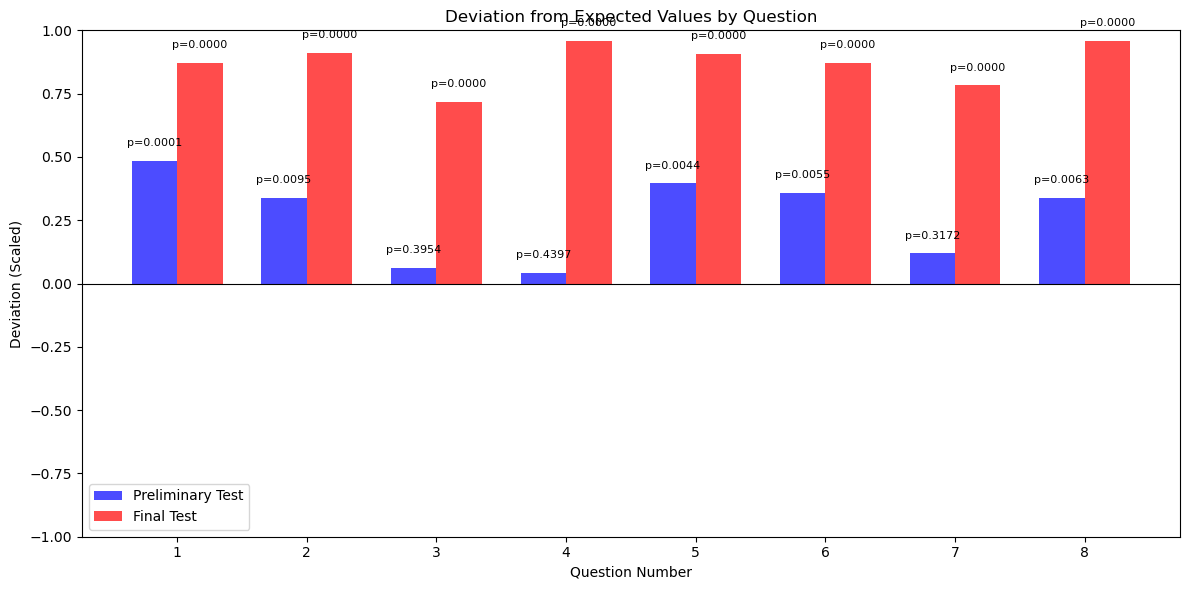

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Initialize lists to store results
results_per_question = []

def analyze_question(questionNum):
    # Get question label
    question = f'Q{questionNum}'

    # Extract probabilities for the question
    probs = data[f'{question}_prob'].values

    # Extract observed responses for preliminary and final minitests
    obs_pm = data[f'{question}_pm'].values.astype(int)
    obs_fm = data[question].values.astype(int)
    n_students = len(probs)

    # Expected total correct responses
    expected_total = probs.sum()

    # Variance and standard deviation
    variances = probs * (1 - probs)
    total_variance = variances.sum()
    std_dev = np.sqrt(total_variance)

    # Z-Score minimum and maximum
    # When all answers are wrong, z_score_min is computed as:
    z_score_min = (0 - expected_total) / std_dev
    # When all answers are correct, z_score_max is computed as:
    z_score_max = (n_students - expected_total) / std_dev

    # Observed total correct responses
    obs_total_pm = obs_pm.sum()
    obs_total_fm = obs_fm.sum()

    # Simulation for p-value
    n_simulations = 10000
    sim_totals = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_totals.append(sim_responses.sum())
    sim_totals = np.array(sim_totals)

    # P-value for preliminary minitest
    p_value_pm = np.mean(sim_totals >= obs_total_pm) if obs_total_pm >= expected_total else np.mean(sim_totals <= obs_total_pm)

    # P-value for final minitest
    p_value_fm = np.mean(sim_totals >= obs_total_fm) if obs_total_fm >= expected_total else np.mean(sim_totals <= obs_total_fm)

    # Calculate z-scores
    z_score_pm = (obs_total_pm - expected_total) / std_dev
    z_score_fm = (obs_total_fm - expected_total) / std_dev

    # Calculate change in z-scores (not absolute value)
    delta_z_score = z_score_fm - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation = z_score_fm / z_score_min if z_score_fm < 0 else z_score_fm / z_score_max
    PM_FM_deviation = delta_z_score / z_score_min if delta_z_score < 0 else delta_z_score / z_score_max

    # Store data for visualization
    results = {
        'question': questionNum,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'obs_total_pm': obs_total_pm,
        'obs_total_fm': obs_total_fm,
        'z_score_pm': z_score_pm,
        'z_score_fm': z_score_fm,
        'delta_z_score': delta_z_score,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation': IRT_FM_deviation,
        'PM-FM_deviation': PM_FM_deviation,
        'p_value_pm': p_value_pm,  # Include p_value_pm in the dictionary
        'p_value_fm': p_value_fm   # Include p_value_fm in the dictionary
    }

    return results

# Analyze each question and collect results
for q_num in range(1, 9):
    result = analyze_question(q_num)
    results_per_question.append(result)

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results_per_question)

# Display the results in the desired format
print(results_df.to_string(index=False))

# Extract deviations and question numbers for plotting
questions = results_df['question']
IRT_PM_deviation = results_df['IRT-PM_deviation']
IRT_FM_deviation = results_df['IRT-FM_deviation']

# Plotting deviations
bar_width = 0.35
index = np.arange(len(questions))

plt.figure(figsize=(12, 6))
plt.bar(index, IRT_PM_deviation, bar_width, label='Preliminary Test', alpha=0.7, color='blue')
plt.bar(index + bar_width, IRT_FM_deviation, bar_width, label='Final Test', alpha=0.7, color='red')

plt.xlabel('Question Number')
plt.ylabel('Deviation (Scaled)')
plt.title('Deviation from Expected Values by Question')
plt.xticks(index + bar_width / 2, questions)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylim(-1, 1)  # Set y-axis limits to reflect -1 to 1 scale

# Adding p-values as text on top of each bar
for i, (pm_dev, fm_dev, q_num) in enumerate(zip(IRT_PM_deviation, IRT_FM_deviation, questions)):
    p_value_pm = results_df.iloc[i]['p_value_pm']
    p_value_fm = results_df.iloc[i]['p_value_fm']
    plt.text(i, pm_dev + 0.05, f'p={p_value_pm:.4f}', ha='center', va='bottom', fontsize=8, color='black')
    plt.text(i + bar_width, fm_dev + 0.05, f'p={p_value_fm:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.legend()
plt.tight_layout()
plt.show()


### To be considered

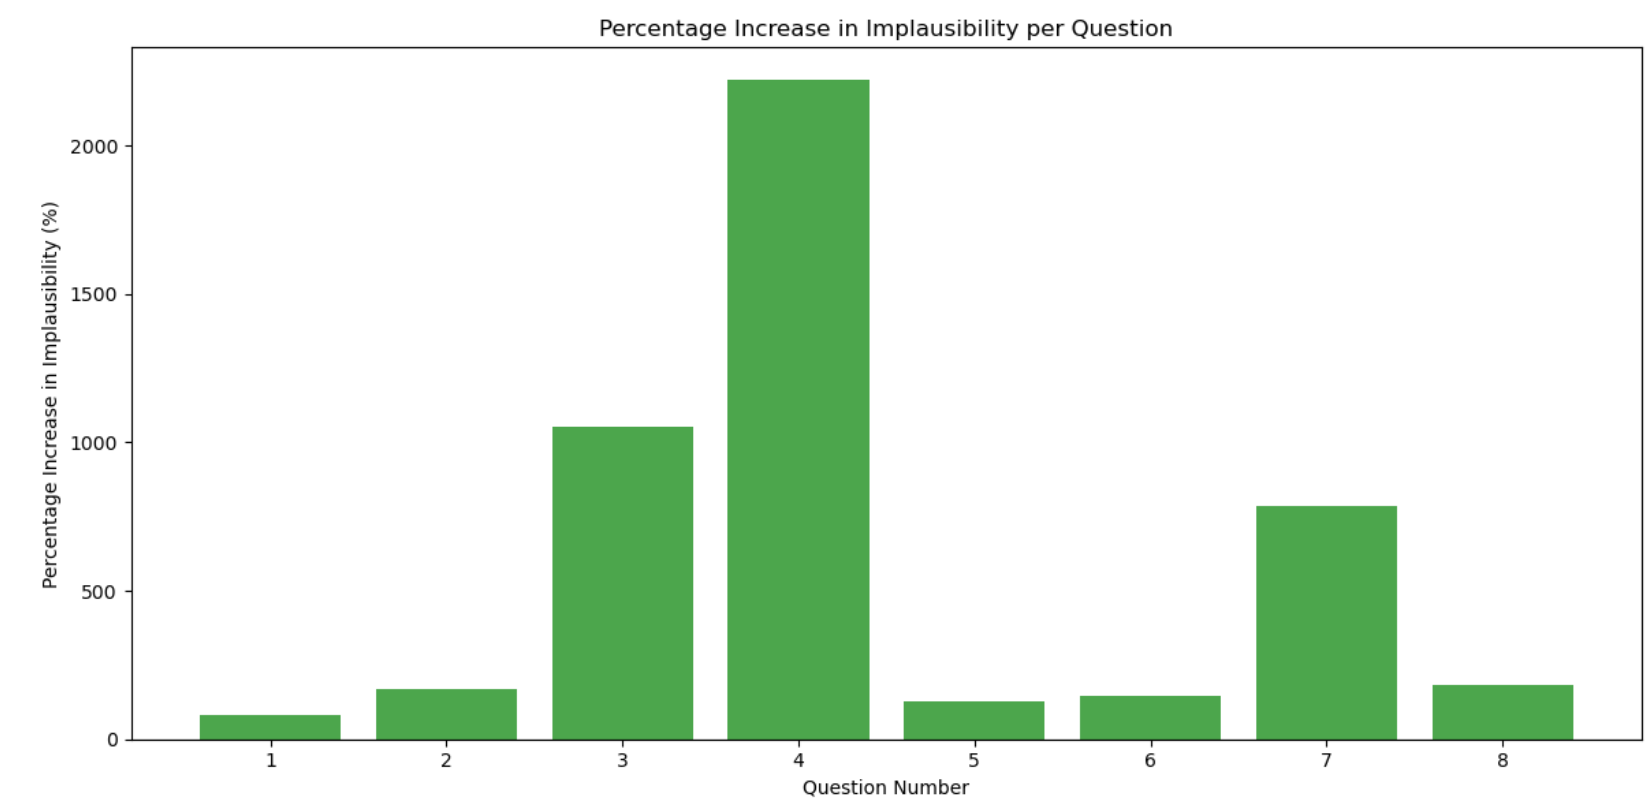

This graph was also produced by a previous version. It may be interesting, since it shows a difference between questions.

# Individual Performance Plausibility in both Preliminary and Final Minitest
Data Preparation: Reads data from CSV files and merges them into a single DataFrame.
Monte Carlo Simulation: Performs 10,000 simulations to compute expected values and confidence intervals.
Result Display: Outputs the results as a formatted table using print.
Visualization: Plots histograms to show the distribution of p-values for the Preliminary and Final Minitests.
By running this code in your environment, you'll be able to see the complete table and the visualizations as needed.

SUBJECT  Observed_Total_PM  Expected  95% CI Lower  95% CI Upper  Plausible_PM  P_Value_PM  Observed_Total_FM  Plausible_FM  P_Value_FM
     S1              0.624  0.478168         0.110      0.803000             1      0.1877              0.808             0      0.0245
     S2              0.680  0.435234         0.096      0.796000             1      0.1108              0.808             0      0.0166
     S3              0.711  0.440290         0.096      0.794000             1      0.0690              0.808             0      0.0163
     S4              0.715  0.435870         0.096      0.790000             1      0.0595              0.808             0      0.0139
     S7              0.471  0.436894         0.096      0.794000             1      0.4507              0.808             0      0.0157
     S8              0.330  0.418064         0.096      0.790000             1      0.6375              0.808             0      0.0122
     S9              0.903  0.479249         0.1

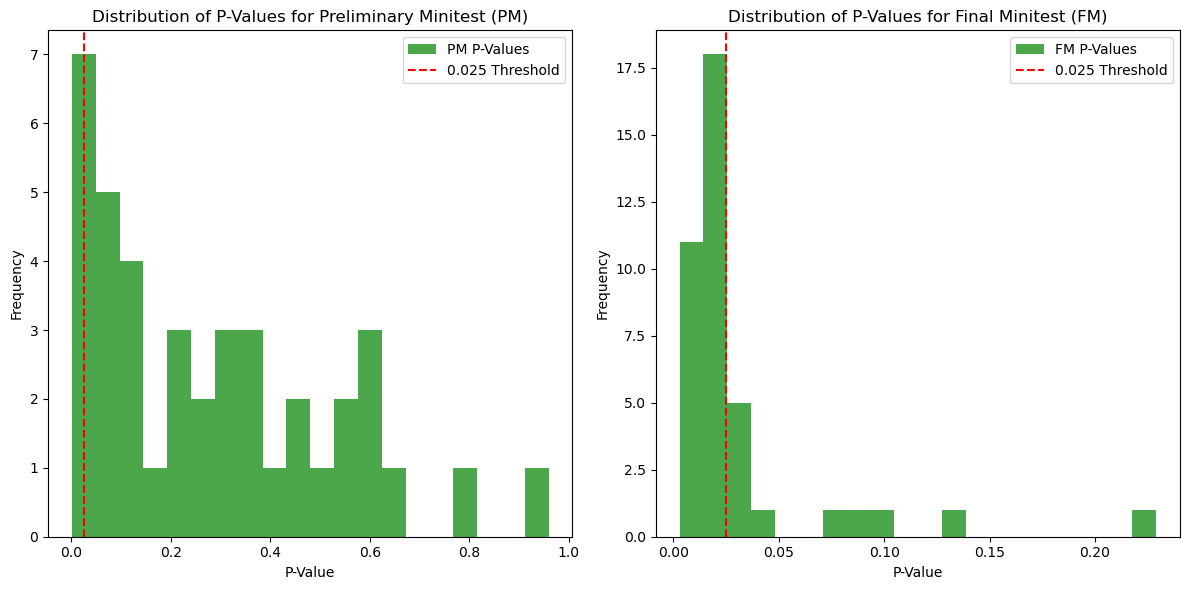

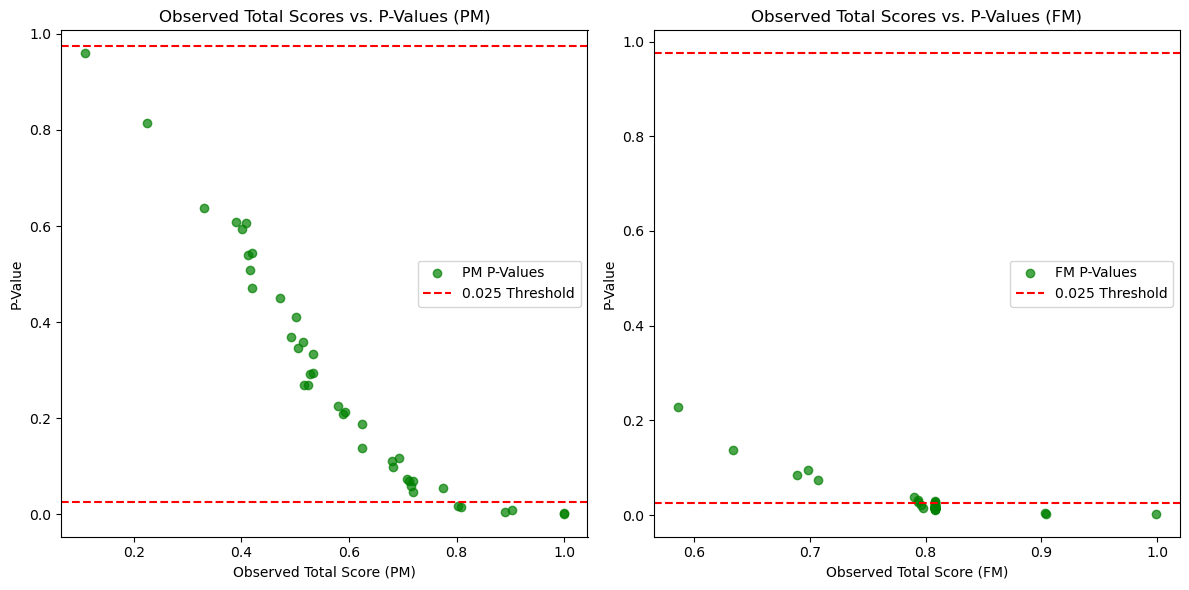

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Simulate scores once for both PM and FM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the common expected values and confidence intervals
    expected_value = np.mean(sim_totals)
    lower_bound = np.percentile(sim_totals, 2.5)
    upper_bound = np.percentile(sim_totals, 97.5)

    # Calculate p-values for PM and FM using the same simulation
    p_value_pm = np.mean(sim_totals >= observed_total_pm)
    p_value_fm = np.mean(sim_totals >= observed_total_fm)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm = 1 if p_value_pm >= 0.025 and p_value_pm <= 0.975 else 0
    plausible_fm = 1 if p_value_fm >= 0.025 and p_value_fm <= 0.975 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected': expected_value,
        '95% CI Lower': lower_bound,
        '95% CI Upper': upper_bound,
        'Plausible_PM': plausible_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM': observed_total_fm,
        'Plausible_FM': plausible_fm,
        'P_Value_FM': p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of P-Values
plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.hist(results_df['P_Value_PM'], bins=20, color='green', alpha=0.7, label='PM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Preliminary Minitest (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.hist(results_df['P_Value_FM'], bins=20, color='green', alpha=0.7, label='FM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Final Minitest (FM)')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.scatter(results_df['Observed_Total_PM'], results_df['P_Value_PM'], color='green', alpha=0.7, label='PM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (PM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.scatter(results_df['Observed_Total_FM'], results_df['P_Value_FM'], color='green', alpha=0.7, label='FM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (FM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (FM)')
plt.legend()

plt.tight_layout()
plt.show()


## Improvement of previous:

SUBJECT  Observed_Total_PM  Expected  99% CI Lower  99% CI Upper  Z_Score_PM  P_Value_PM  Observed_Total_FM_NCQ  Z_Score_FM_NCQ  P_Value_FM_NCQ  Observed_Total_FM_CQ  Z_Score_FM_CQ  P_Value_FM_CQ  Delta_Z_NCQ  Delta_Z_CQ  Percentage_Change_NCQ  Percentage_Change_CQ
     S1              0.624  0.474314      0.095000      0.903005    0.819922      0.1877                  0.904        2.353654          0.0050                 0.528       0.294071         0.3547     1.533732   -0.525851             187.058242            -64.134254
     S2              0.680  0.438184      0.000000      0.893000    1.341445      0.1156                  0.904        2.584059          0.0029                 0.584       0.808896         0.2312     1.242614   -0.532549              92.632491            -39.699639
     S3              0.711  0.440579      0.000000      0.893000    1.511966      0.0660                  0.999        3.122218          0.0013                 0.520       0.444056         0.2971     1.

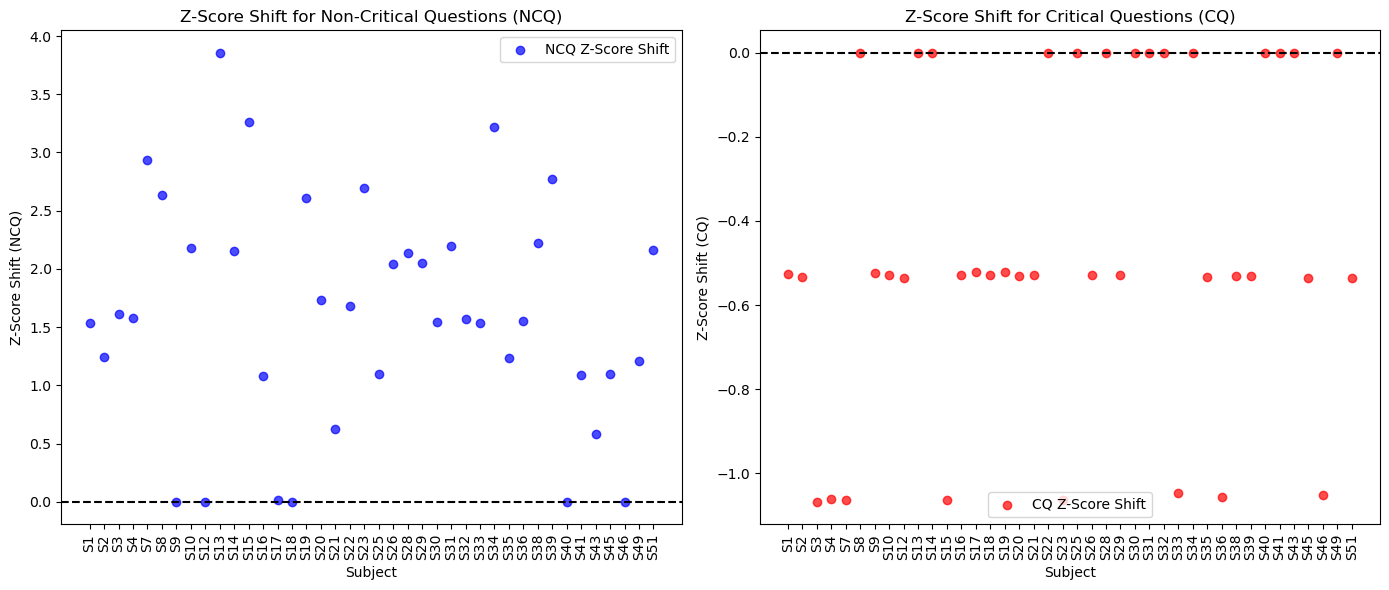

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')


# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM
    observed_total_pm = np.dot(obs_pm, question_values)

    # Simulate scores once for PM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the expected value and 99% confidence interval (instead of 95%)
    expected_value = np.mean(sim_totals)
    lower_bound = np.percentile(sim_totals, 0.5)
    upper_bound = np.percentile(sim_totals, 99.5)

    # Calculate the z-score and p-value for PM
    std_dev = np.std(sim_totals)
    z_score_pm = (observed_total_pm - expected_value) / std_dev
    p_value_pm = np.mean(sim_totals >= observed_total_pm)

    # NCQ: FM answers (correct direction) - use only NCQ indices for FM, copy PM for CQ
    obs_fm_ncq = obs_fm.copy()
    obs_fm_ncq[cq_indices] = obs_pm[cq_indices]  # Copy PM values for CQ questions
    observed_total_fm_ncq = np.dot(obs_fm_ncq, question_values)
    
    # Calculate z-score and p-value for FM (NCQ)
    z_score_fm_ncq = (observed_total_fm_ncq - expected_value) / std_dev
    p_value_fm_ncq = np.mean(sim_totals >= observed_total_fm_ncq)

    # CQ: FM answers (wrong direction) - use only CQ indices for FM, copy PM for NCQ
    obs_fm_cq = obs_fm.copy()
    obs_fm_cq[ncq_indices] = obs_pm[ncq_indices]  # Copy PM values for NCQ questions
    observed_total_fm_cq = np.dot(obs_fm_cq, question_values)
    
    # Calculate z-score and p-value for FM (CQ)
    z_score_fm_cq = (observed_total_fm_cq - expected_value) / std_dev
    p_value_fm_cq = np.mean(sim_totals >= observed_total_fm_cq)

    # Calculate z-score shifts
    delta_z_ncq = z_score_fm_ncq - z_score_pm
    delta_z_cq = z_score_fm_cq - z_score_pm

    # Percentage change in z-scores
    percentage_change_ncq = (delta_z_ncq / abs(z_score_pm)) * 100 if z_score_pm != 0 else 0
    percentage_change_cq = (delta_z_cq / abs(z_score_pm)) * 100 if z_score_pm != 0 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected': expected_value,
        '99% CI Lower': lower_bound,
        '99% CI Upper': upper_bound,
        'Z_Score_PM': z_score_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM_NCQ': observed_total_fm_ncq,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'Observed_Total_FM_CQ': observed_total_fm_cq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'P_Value_FM_CQ': p_value_fm_cq,
        'Delta_Z_NCQ': delta_z_ncq,
        'Delta_Z_CQ': delta_z_cq,
        'Percentage_Change_NCQ': percentage_change_ncq,
        'Percentage_Change_CQ': percentage_change_cq
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of Z-Score Shifts for NCQ and CQ

plt.figure(figsize=(14, 6))

# Plot Z-Score Shift for NCQ
plt.subplot(1, 2, 1)
plt.scatter(results_df['SUBJECT'], results_df['Delta_Z_NCQ'], color='blue', label='NCQ Z-Score Shift', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Subject')
plt.ylabel('Z-Score Shift (NCQ)')
plt.title('Z-Score Shift for Non-Critical Questions (NCQ)')
plt.xticks(rotation=90)
plt.legend()

# Plot Z-Score Shift for CQ
plt.subplot(1, 2, 2)
plt.scatter(results_df['SUBJECT'], results_df['Delta_Z_CQ'], color='red', label='CQ Z-Score Shift', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Subject')
plt.ylabel('Z-Score Shift (CQ)')
plt.title('Z-Score Shift for Critical Questions (CQ)')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


## HERE:

SUBJECT  Z_Score_PM  Z_Score_NCQ  Z_Score_CQ  Summed_Z_Scores
     S1    0.819366     0.945904   -0.126538         0.819366
     S2    1.346612     1.388352   -0.041741         1.346612
     S3    1.495715     1.022082    0.473633         1.495715
     S4    1.537276     1.054539    0.482737         1.537276
     S7    0.189241    -0.294040    0.483281         0.189241
     S8   -0.496871     0.033418   -0.530289        -0.496871
     S9    2.348422     2.485255   -0.136833         2.348422
    S10    0.333472    -0.160091    0.493563         0.333472
    S12    3.131237     2.639276    0.491961         3.131237
    S13   -1.791864    -1.225679   -0.566185        -1.791864
    S14   -0.225642     0.401109   -0.626752        -0.225642
    S15   -0.179302    -0.641643    0.462341        -0.179302
    S16    0.862543     0.370058    0.492485         0.862543
    S17    2.575844     2.065411    0.510433         2.575844
    S18    1.987546     1.520417    0.467129         1.987546
    S19 

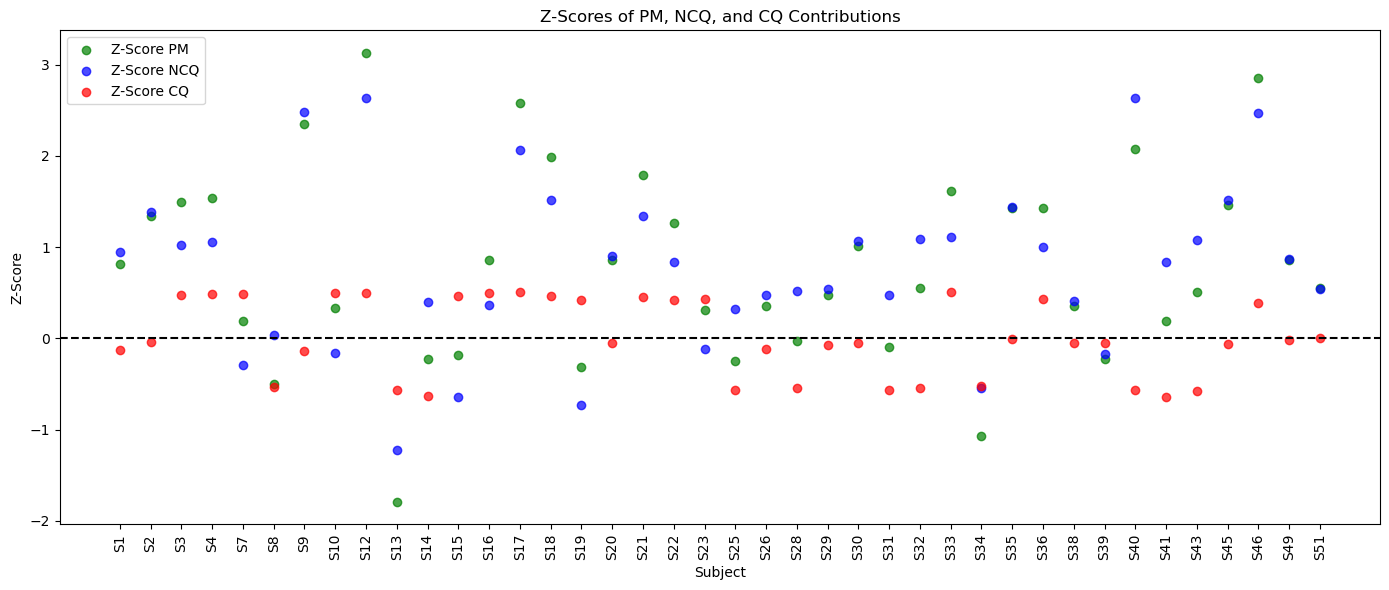

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Calculate expected totals, variance, and standard deviation for overall PM
    expected_total = np.sum(probs * question_values)
    variances = probs * (1 - probs) * (question_values ** 2)
    std_dev = np.sqrt(variances.sum())

    # Calculate Z-Score for overall PM
    z_score_pm = (observed_total_pm - expected_total) / std_dev

    # Calculate expected totals, variance, and standard deviation for NCQ and CQ separately
    expected_ncq = np.sum(probs[ncq_indices] * question_values[ncq_indices])
    variance_ncq = np.sum(probs[ncq_indices] * (1 - probs[ncq_indices]) * (question_values[ncq_indices] ** 2))
    std_dev_ncq = np.sqrt(variance_ncq)

    expected_cq = np.sum(probs[cq_indices] * question_values[cq_indices])
    variance_cq = np.sum(probs[cq_indices] * (1 - probs[cq_indices]) * (question_values[cq_indices] ** 2))
    std_dev_cq = np.sqrt(variance_cq)

    # Calculate observed totals for NCQ and CQ
    observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
    observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ
    z_score_pm_ncq = (observed_total_pm_ncq - expected_ncq) / std_dev
    z_score_pm_cq = (observed_total_pm_cq - expected_cq) / std_dev

    # Convert z-scores to raw deviations for summation
    raw_deviation_pm_ncq = (observed_total_pm_ncq - expected_ncq)
    raw_deviation_pm_cq = (observed_total_pm_cq - expected_cq)

    # Calculate summed raw deviation and convert to overall z-score
    total_raw_deviation_pm = raw_deviation_pm_ncq + raw_deviation_pm_cq
    summed_z_scores_pm_corrected = total_raw_deviation_pm / std_dev

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Z_Score_PM': z_score_pm,
        'Z_Score_NCQ': z_score_pm_ncq,
        'Z_Score_CQ': z_score_pm_cq,
        'Summed_Z_Scores': summed_z_scores_pm_corrected
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of Z-Score Contributions

plt.figure(figsize=(14, 6))

# Plot Z-Score for PM, NCQ, and CQ
plt.scatter(results_df['SUBJECT'], results_df['Z_Score_PM'], color='green', label='Z-Score PM', alpha=0.7)
plt.scatter(results_df['SUBJECT'], results_df['Z_Score_NCQ'], color='blue', label='Z-Score NCQ', alpha=0.7)
plt.scatter(results_df['SUBJECT'], results_df['Z_Score_CQ'], color='red', label='Z-Score CQ', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Subject')
plt.ylabel('Z-Score')
plt.title('Z-Scores of PM, NCQ, and CQ Contributions')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Calculate expected totals, variance, and standard deviation for overall PM and FM
    expected_total = np.sum(probs * question_values)
    variances = probs * (1 - probs) * (question_values ** 2)
    std_dev = np.sqrt(variances.sum())

    # Calculate Z-Scores for overall PM and FM
    z_score_pm = (observed_total_pm - expected_total) / std_dev
    z_score_fm = (observed_total_fm - expected_total) / std_dev

    # Calculate expected totals, variance, and standard deviation for NCQ and CQ separately
    expected_ncq = np.sum(probs[ncq_indices] * question_values[ncq_indices])
    variance_ncq = np.sum(probs[ncq_indices] * (1 - probs[ncq_indices]) * (question_values[ncq_indices] ** 2))
    std_dev_ncq = np.sqrt(variance_ncq)

    expected_cq = np.sum(probs[cq_indices] * question_values[cq_indices])
    variance_cq = np.sum(probs[cq_indices] * (1 - probs[cq_indices]) * (question_values[cq_indices] ** 2))
    std_dev_cq = np.sqrt(variance_cq)

    # Calculate observed totals for NCQ and CQ in PM
    observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
    observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in PM
    z_score_pm_ncq = (observed_total_pm_ncq - expected_ncq) / std_dev
    z_score_pm_cq = (observed_total_pm_cq - expected_cq) / std_dev

    # Calculate observed totals for NCQ and CQ in FM
    observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
    observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in FM
    z_score_fm_ncq = (observed_total_fm_ncq - expected_ncq) / std_dev
    z_score_fm_cq = (observed_total_fm_cq - expected_cq) / std_dev

    # Monte Carlo simulation for p-values
    sim_totals_pm = []
    sim_totals_fm = []
    sim_totals_pm_ncq = []
    sim_totals_pm_cq = []
    sim_totals_fm_ncq = []
    sim_totals_fm_cq = []
    for _ in range(n_simulations):
            sim_responses = np.random.binomial(1, probs)
            sim_total = np.dot(sim_responses, question_values)
            sim_total_ncq = np.dot(sim_responses[ncq_indices], question_values[ncq_indices])
            sim_total_cq = np.dot(sim_responses[cq_indices], question_values[cq_indices])

            sim_totals_pm.append(sim_total)
            sim_totals_fm.append(sim_total)
            sim_totals_pm_ncq.append(sim_total_ncq)
            sim_totals_pm_cq.append(sim_total_cq)
            sim_totals_fm_ncq.append(sim_total_ncq)
            sim_totals_fm_cq.append(sim_total_cq)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_totals_pm_ncq = np.array(sim_totals_pm_ncq)
    sim_totals_pm_cq = np.array(sim_totals_pm_cq)
    sim_totals_fm_ncq = np.array(sim_totals_fm_ncq)
    sim_totals_fm_cq = np.array(sim_totals_fm_cq)

    # Calculate p-values for PM and FM (Overall, NCQ, and CQ)
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals_pm <= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals_fm <= observed_total_fm)
    p_value_pm_ncq = np.mean(sim_totals_pm_ncq >= observed_total_pm_ncq) if observed_total_pm_ncq >= expected_ncq else np.mean(sim_totals_pm_ncq <= observed_total_pm_ncq)
    p_value_pm_cq = np.mean(sim_totals_pm_cq >= observed_total_pm_cq) if observed_total_pm_cq >= expected_cq else np.mean(sim_totals_pm_cq <= observed_total_pm_cq)
    p_value_fm_ncq = np.mean(sim_totals_fm_ncq >= observed_total_fm_ncq) if observed_total_fm_ncq >= expected_ncq else np.mean(sim_totals_fm_ncq <= observed_total_fm_ncq)
    p_value_fm_cq = np.mean(sim_totals_fm_cq >= observed_total_fm_cq) if observed_total_fm_cq >= expected_cq else np.mean(sim_totals_fm_cq <= observed_total_fm_cq)

    # Calculate z-score min and max for NCQ and CQ
    z_score_ncq_min = (0 - expected_ncq) / std_dev
    z_score_ncq_max = (np.sum(question_values[ncq_indices]) - expected_ncq) / std_dev
    z_score_cq_min = (0 - expected_cq) / std_dev
    z_score_cq_max = (np.sum(question_values[cq_indices]) - expected_cq) / std_dev

    # Calculate z-score min and max for overall PM and FM
    z_score_min = (0 - expected_total) / std_dev
    z_score_max = (np.sum(question_values) - expected_total) / std_dev

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'z_score_NCQ_min': z_score_ncq_min,
        'z_score_NCQ_max': z_score_ncq_max,
        'z_score_CQ_min': z_score_cq_min,
        'z_score_CQ_max': z_score_cq_max,
        'Observed_Total_PM': observed_total_pm,
        'Z_Score_PM': z_score_pm,
        'Z_Score_PM_NCQ': z_score_pm_ncq,
        'Z_Score_PM_CQ': z_score_pm_cq,
        'Observed_Total_FM': observed_total_fm,
        'Z_Score_FM': z_score_fm,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'P_Value_PM': p_value_pm,  # Corrected P-Value for PM (Overall)
        'P_Value_PM_NCQ': p_value_pm_ncq,
        'P_Value_PM_CQ': p_value_pm_cq,
        'P_Value_FM': p_value_fm,  # Corrected P-Value for FM (Overall)
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'P_Value_FM_CQ': p_value_fm_cq
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


SUBJECT  expected_total  std_dev  z_score_min  z_score_max  z_score_NCQ_min  z_score_NCQ_max  z_score_CQ_min  z_score_CQ_max  Observed_Total_PM  Z_Score_PM  Z_Score_PM_NCQ  Z_Score_PM_CQ  Observed_Total_FM  Z_Score_FM  Z_Score_FM_NCQ  Z_Score_FM_CQ  P_Value_PM  P_Value_PM_NCQ  P_Value_PM_CQ  P_Value_FM  P_Value_FM_NCQ  P_Value_FM_CQ
     S1        0.475671 0.181029    -2.627596     2.890858        -1.970757         2.492618       -0.656840        0.398240              0.624    0.819366        0.945904      -0.126538              0.808    1.835778        2.492618      -0.656840      0.1901          0.1408         0.6061      0.0245          0.0086         0.1421
     S2        0.436587 0.180760    -2.415291     3.111387        -1.842458         2.627568       -0.572833        0.483819              0.680    1.346612        1.388352      -0.041741              0.808    2.054735        2.627568      -0.572833      0.1108          0.1013         0.7076      0.0155          0.0059         0.

# Below the version I thought was final:

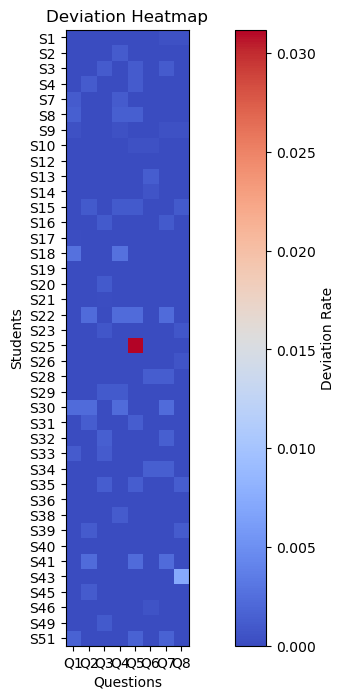

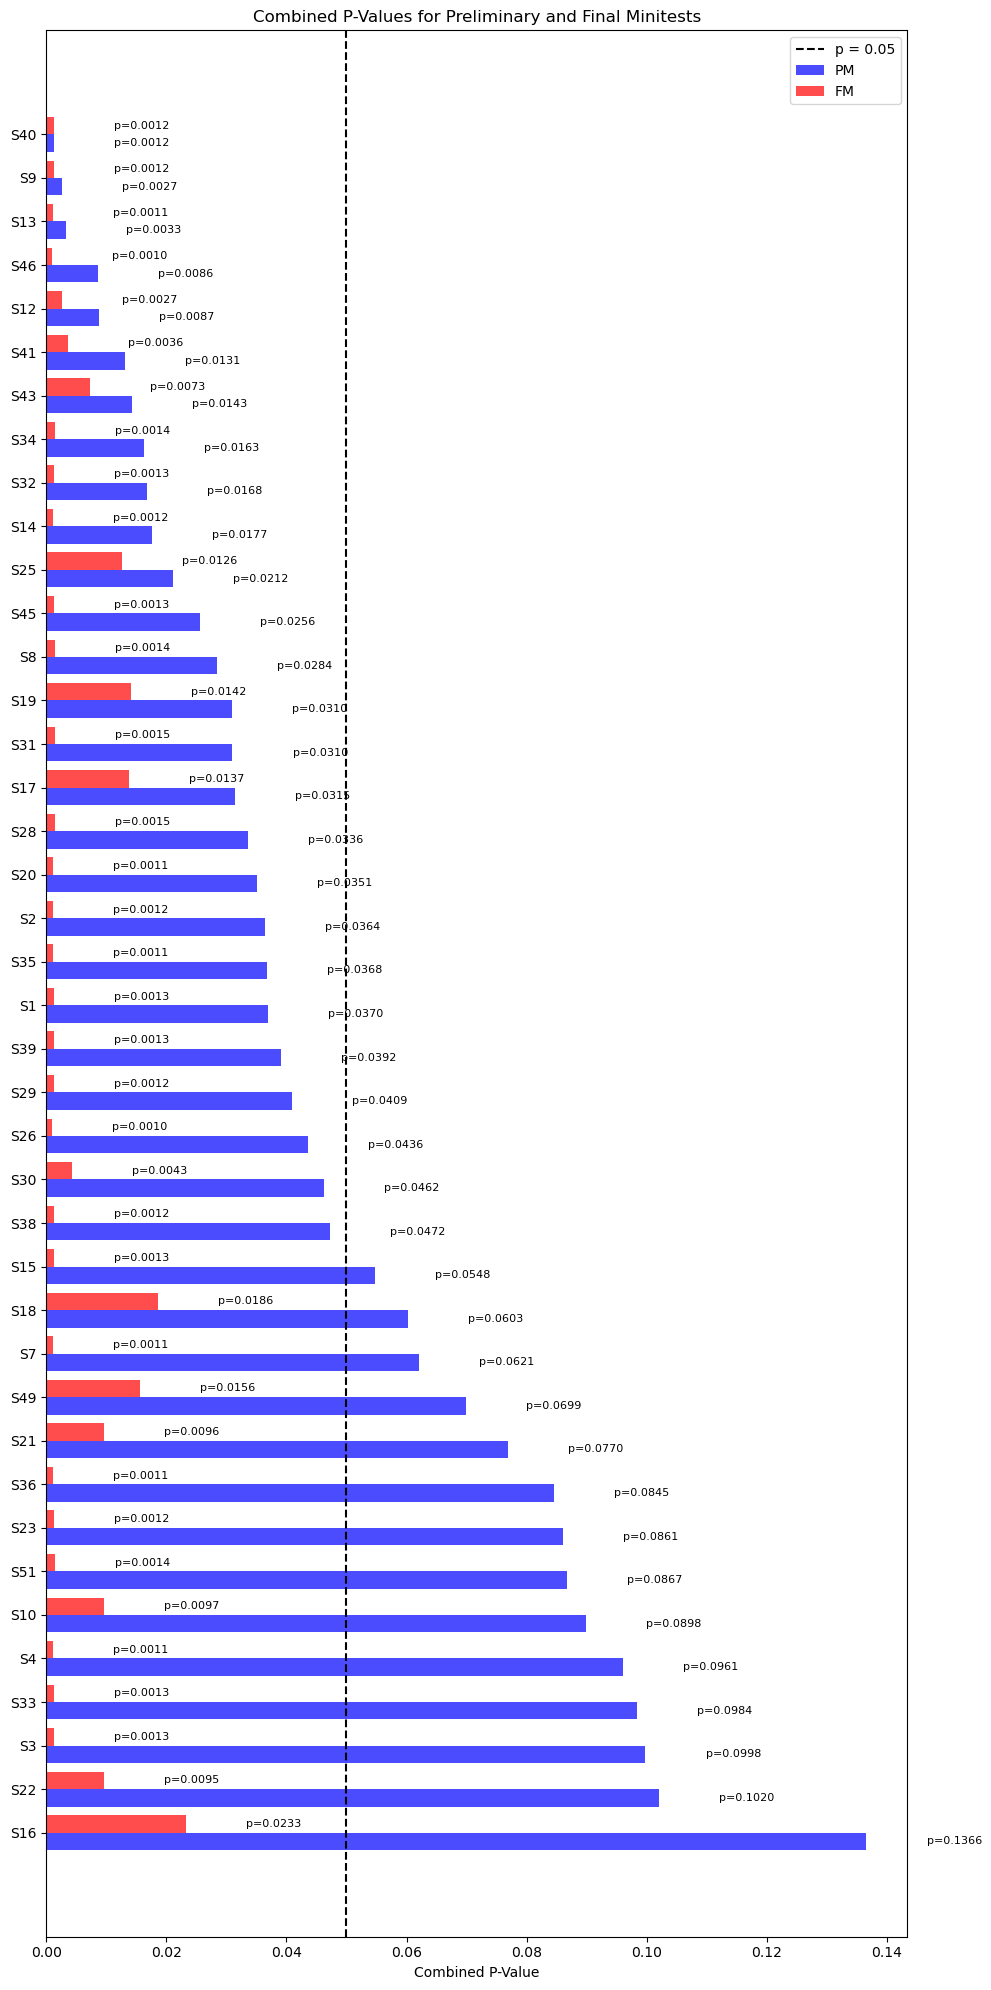

SUBJECT  expected_total  std_dev  Observed_Total_PM  Z_Score_PM  P_Value_PM  Z_Score_PM_NCQ  P_Value_PM_NCQ  Z_Score_PM_CQ  P_Value_PM_CQ  Observed_Total_FM  Z_Score_FM  P_Value_FM  Z_Score_FM_NCQ  P_Value_FM_NCQ  Z_Score_FM_CQ  P_Value_FM_CQ  Combined_P_Value_PM  Combined_P_Value_FM
     S1        0.475605 0.181774              0.624    0.816369      0.1897        0.288242          0.3499      -2.088332         0.0173              0.808    1.828613      0.0267        1.828613          0.0267      -2.616460         0.0050             0.036968             0.001325
     S2        0.437673 0.179503              0.680    1.349989      0.1132        0.815178          0.2288      -1.903446         0.0260              0.808    2.063071      0.0146        2.063071          0.0146      -2.438257         0.0082             0.036434             0.001201
     S3        0.438395 0.181300              0.711    1.503614      0.0667        0.450112          0.3040      -1.364561         0.0671        

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    # Load and prepare the data
    prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
    pm_df = pd.read_csv('PreliminaryResults_8q.csv')
    fm_df = pd.read_csv('FinalResults_8q.csv')
    
    # Rename columns for easier reference
    prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']
    prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
    pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
    fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

    # Merge dataframes
    data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
    data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

    # Define question values (weights) and indices
    question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])
    ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
    cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

    return data, question_values, ncq_indices, cq_indices

def calculate_p_values(data, question_values, n_simulations=10000):
    results = []
    for _, row in data.iterrows():
        subject_id = row['SUBJECT']
        probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
        obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
        obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

        # Calculate observed totals for PM and FM
        observed_total_pm = np.dot(obs_pm, question_values)
        observed_total_fm = np.dot(obs_fm, question_values)
        
        # Simulate responses to compute expected value and CI
        sim_totals = []
        for _ in range(n_simulations):
            sim_responses = np.random.binomial(1, probs)
            sim_total = np.dot(sim_responses, question_values)
            sim_totals.append(sim_total)
        
        sim_totals = np.array(sim_totals)
        expected_total = np.mean(sim_totals)
        std_dev = np.std(sim_totals)

        # Calculate overall p-values and z-scores for PM and FM
        z_score_pm = (observed_total_pm - expected_total) / std_dev
        p_value_pm = np.mean(sim_totals >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals <= observed_total_pm)
        
        z_score_fm = (observed_total_fm - expected_total) / std_dev
        p_value_fm = np.mean(sim_totals >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals <= observed_total_fm)

        # Store overall results
        results.append({
            'SUBJECT': subject_id,
            'expected_total': expected_total,
            'std_dev': std_dev,
            'Observed_Total_PM': observed_total_pm,
            'Z_Score_PM': z_score_pm,
            'P_Value_PM': p_value_pm,
            'Observed_Total_FM': observed_total_fm,
            'Z_Score_FM': z_score_fm,
            'P_Value_FM': p_value_fm
        })
    
    return pd.DataFrame(results)

def calculate_deviation_rates(results_df):
    # Calculate deviation rates for students and questions
    results_df['student_deviation_rate'] = np.minimum(0.05, results_df['P_Value_PM']) - results_df['P_Value_FM']
    results_df['question_deviation_rate'] = results_df.apply(lambda row: np.minimum(0.05, row['P_Value_PM']) - row['P_Value_FM'], axis=1)
    
    return results_df

def generate_final_deviation_matrix(conformity_matrix, results_df, deviation_rate_col):
    # Create a matrix to store the final deviation values for the heatmap
    final_deviation_matrix = np.zeros_like(conformity_matrix, dtype=float)

    for student_index, row in results_df.iterrows():
        for question_index in range(8):
            if conformity_matrix[student_index][question_index] == 1:
                # Calculate final deviation as the product of student and question deviation rates
                final_deviation_matrix[student_index][question_index] = (
                    row[deviation_rate_col] * row['question_deviation_rate']
                )
    
    return final_deviation_matrix

def plot_deviation_heatmap(final_deviation_matrix, students, questions):
    plt.figure(figsize=(12, 8))
    plt.imshow(final_deviation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Deviation Rate')
    plt.xticks(ticks=np.arange(len(questions)), labels=questions)
    plt.yticks(ticks=np.arange(len(students)), labels=students)
    plt.title('Deviation Heatmap')
    plt.xlabel('Questions')
    plt.ylabel('Students')
    plt.show()

    

def calculate_and_populate_tables(data, question_values, ncq_indices, cq_indices, n_simulations=10000):
    results = []
    student_results = []

    for _, row in data.iterrows():
        subject_id = row['SUBJECT']
        probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
        obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
        obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

        # Simulate responses to compute expected value and CI
        sim_totals = []
        for _ in range(n_simulations):
            sim_responses = np.random.binomial(1, probs)
            sim_total = np.dot(sim_responses, question_values)
            sim_totals.append(sim_total)
        
        sim_totals = np.array(sim_totals)
        expected_total = np.mean(sim_totals)
        std_dev = np.std(sim_totals)

        # Overall Z-Scores and P-Values
        observed_total_pm = np.dot(obs_pm, question_values)
        z_score_pm = (observed_total_pm - expected_total) / std_dev
        p_value_pm = np.mean(sim_totals >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals <= observed_total_pm)

        observed_total_fm = np.dot(obs_fm, question_values)
        z_score_fm = (observed_total_fm - expected_total) / std_dev
        p_value_fm = np.mean(sim_totals >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals <= observed_total_fm)

        # Calculating Z-Scores and P-Values for NCQ and CQ
        observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
        observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])
        observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
        observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

        # NCQ and CQ simulations
        z_score_pm_ncq = (observed_total_pm_ncq - expected_total) / std_dev
        p_value_pm_ncq = np.mean(sim_totals >= observed_total_pm_ncq) if observed_total_pm_ncq >= expected_total else np.mean(sim_totals <= observed_total_pm_ncq)

        z_score_pm_cq = (observed_total_pm_cq - expected_total) / std_dev
        p_value_pm_cq = np.mean(sim_totals >= observed_total_pm_cq) if observed_total_pm_cq >= expected_total else np.mean(sim_totals <= observed_total_pm_cq)

        z_score_fm_ncq = (observed_total_fm_ncq - expected_total) / std_dev
        p_value_fm_ncq = np.mean(sim_totals >= observed_total_fm_ncq) if observed_total_fm_ncq >= expected_total else np.mean(sim_totals <= observed_total_fm_ncq)

        z_score_fm_cq = (observed_total_fm_cq - expected_total) / std_dev
        p_value_fm_cq = np.mean(sim_totals >= observed_total_fm_cq) if observed_total_fm_cq >= expected_total else np.mean(sim_totals <= observed_total_fm_cq)

        # Calculate Combined P-Values for PM and FM using Fisher's method
        _, combined_p_value_pm = combine_pvalues([p_value_pm_ncq, p_value_pm_cq], method='fisher')
        _, combined_p_value_fm = combine_pvalues([p_value_fm_ncq, p_value_fm_cq], method='fisher')

        # Store the results for each student
        student_results.append({
            'SUBJECT': subject_id,
            'expected_total': expected_total,
            'std_dev': std_dev,
            'Observed_Total_PM': observed_total_pm,
            'Z_Score_PM': z_score_pm,
            'P_Value_PM': p_value_pm,
            'Z_Score_PM_NCQ': z_score_pm_ncq,
            'P_Value_PM_NCQ': p_value_pm_ncq,
            'Z_Score_PM_CQ': z_score_pm_cq,
            'P_Value_PM_CQ': p_value_pm_cq,
            'Observed_Total_FM': observed_total_fm,
            'Z_Score_FM': z_score_fm,
            'P_Value_FM': p_value_fm,
            'Z_Score_FM_NCQ': z_score_fm_ncq,
            'P_Value_FM_NCQ': p_value_fm_ncq,
            'Z_Score_FM_CQ': z_score_fm_cq,
            'P_Value_FM_CQ': p_value_fm_cq,
            'Combined_P_Value_PM': combined_p_value_pm,
            'Combined_P_Value_FM': combined_p_value_fm
        })

    # Convert the list of dictionaries to DataFrame
    student_results_df = pd.DataFrame(student_results)
    return student_results_df

def plot_combined_pvalues(data):
    """
    This function generates a bar plot for each student with combined p-values for PM and FM.
    The blue bar represents the PM combined p-value, and the red bar represents the FM combined p-value.
    A dotted line indicates the 0.05 threshold for significance.
    
    Parameters:
    - data: A DataFrame containing columns 'SUBJECT', 'Combined_P_Value_PM', and 'Combined_P_Value_FM'.
    """
    # Define the p-value threshold
    p_value_threshold = 0.05
    
    # Sort data by Combined_P_Value_PM to have a consistent order in the plot
    data = data.sort_values('Combined_P_Value_PM', ascending=False)
    
    # Number of students
    n_students = len(data)
    
    # Create the plot
    plt.figure(figsize=(10, n_students * 0.5))  # Adjust height based on number of students
    y_positions = np.arange(n_students)
    
    # Plotting the combined p-values
    plt.barh(y_positions, data['Combined_P_Value_PM'], color='blue', alpha=0.7, height=0.4, label='PM')
    plt.barh(y_positions + 0.4, data['Combined_P_Value_FM'], color='red', alpha=0.7, height=0.4, label='FM')
    
    # Add the significance threshold line
    plt.axvline(p_value_threshold, color='black', linestyle='--', label=f'p = {p_value_threshold}')
    
    # Annotate each bar with its p-value
    for i, (pm, fm) in enumerate(zip(data['Combined_P_Value_PM'], data['Combined_P_Value_FM'])):
        plt.text(pm + 0.01, y_positions[i], f'p={pm:.4f}', va='center', ha='left', fontsize=8, color='black')
        plt.text(fm + 0.01, y_positions[i] + 0.4, f'p={fm:.4f}', va='center', ha='left', fontsize=8, color='black')
    
    # Labels and legend
    plt.xlabel('Combined P-Value')
    plt.yticks(y_positions + 0.2, data['SUBJECT'])
    plt.title('Combined P-Values for Preliminary and Final Minitests')
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `results_df` is the DataFrame produced by `calculate_and_populate_tables`
# plot_combined_pvalues(results_df)



# Main Program Execution
if __name__ == "__main__":
    data, question_values, ncq_indices, cq_indices = load_data()
    results_df = calculate_p_values(data, question_values)
    results_df = calculate_deviation_rates(results_df)


    # Conformity matrix example: replace with actual conformity data
    conformity_matrix = np.random.choice([0, 1, -1], size=(len(results_df), 8), p=[0.7, 0.2, 0.1])
    
    final_deviation_matrix = generate_final_deviation_matrix(conformity_matrix, results_df, 'student_deviation_rate')
    
    students = results_df['SUBJECT'].tolist()
    questions = [f'Q{num}' for num in range(1, 9)]
    
    plot_deviation_heatmap(final_deviation_matrix, students, questions)
    
    # Step 2: Calculate Z-Scores and P-Values for PM and FM, and populate the tables
    results_df = calculate_and_populate_tables(data, question_values, ncq_indices, cq_indices)

    
    plot_combined_pvalues(results_df)
    
    # Display the resulting DataFrame
    print(results_df.to_string(index=False))
    

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student
n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Calculate expected totals, variance, and standard deviation for overall PM and FM
    expected_total = np.sum(probs * question_values)
    variances = probs * (1 - probs) * (question_values ** 2)
    std_dev = np.sqrt(variances.sum())

    # Calculate Z-Scores for overall PM and FM
    z_score_pm = (observed_total_pm - expected_total) / std_dev
    z_score_fm = (observed_total_fm - expected_total) / std_dev

    # Calculate expected totals, variance, and standard deviation for NCQ and CQ separately
    expected_ncq = np.sum(probs[ncq_indices] * question_values[ncq_indices])
    variance_ncq = np.sum(probs[ncq_indices] * (1 - probs[ncq_indices]) * (question_values[ncq_indices] ** 2))
    std_dev_ncq = np.sqrt(variance_ncq)

    expected_cq = np.sum(probs[cq_indices] * question_values[cq_indices])
    variance_cq = np.sum(probs[cq_indices] * (1 - probs[cq_indices]) * (question_values[cq_indices] ** 2))
    std_dev_cq = np.sqrt(variance_cq)

    # Calculate observed totals for NCQ and CQ in PM
    observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
    observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in PM
    z_score_pm_ncq = (observed_total_pm_ncq - expected_ncq) / std_dev
    z_score_pm_cq = (observed_total_pm_cq - expected_cq) / std_dev

    # Calculate observed totals for NCQ and CQ in FM
    observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
    observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in FM
    z_score_fm_ncq = (observed_total_fm_ncq - expected_ncq) / std_dev
    z_score_fm_cq = (observed_total_fm_cq - expected_cq) / std_dev

    # Monte Carlo simulation for p-values
    sim_totals_pm = []
    sim_totals_fm = []
    sim_totals_pm_ncq = []
    sim_totals_pm_cq = []
    sim_totals_fm_ncq = []
    sim_totals_fm_cq = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_total_ncq = np.dot(sim_responses[ncq_indices], question_values[ncq_indices])
        sim_total_cq = np.dot(sim_responses[cq_indices], question_values[cq_indices])

        sim_totals_pm.append(sim_total)
        sim_totals_fm.append(sim_total)
        sim_totals_pm_ncq.append(sim_total_ncq)
        sim_totals_pm_cq.append(sim_total_cq)
        sim_totals_fm_ncq.append(sim_total_ncq)
        sim_totals_fm_cq.append(sim_total_cq)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_totals_pm_ncq = np.array(sim_totals_pm_ncq)
    sim_totals_pm_cq = np.array(sim_totals_pm_cq)
    sim_totals_fm_ncq = np.array(sim_totals_fm_ncq)
    sim_totals_fm_cq = np.array(sim_totals_fm_cq)

    # Calculate p-values for PM and FM (Overall, NCQ, and CQ)
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals_pm <= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals_fm <= observed_total_fm)
    p_value_pm_ncq = np.mean(sim_totals_pm_ncq >= observed_total_pm_ncq) if observed_total_pm_ncq >= expected_ncq else np.mean(sim_totals_pm_ncq <= observed_total_pm_ncq)
    p_value_pm_cq = np.mean(sim_totals_pm_cq >= observed_total_pm_cq) if observed_total_pm_cq >= expected_cq else np.mean(sim_totals_pm_cq <= observed_total_pm_cq)
    p_value_fm_ncq = np.mean(sim_totals_fm_ncq >= observed_total_fm_ncq) if observed_total_fm_ncq >= expected_ncq else np.mean(sim_totals_fm_ncq <= observed_total_fm_ncq)
    p_value_fm_cq = np.mean(sim_totals_fm_cq >= observed_total_fm_cq) if observed_total_fm_cq >= expected_cq else np.mean(sim_totals_fm_cq <= observed_total_fm_cq)

    # Calculate combined p-values using Fisher's method
    def calculate_combined_p_value(p_value_ncq, p_value_cq):
        fisher_statistic = -2 * (np.log(p_value_ncq) + np.log(p_value_cq))
        combined_p_value = 1 - chi2.cdf(fisher_statistic, df=4)  # df = 2*number_of_tests
        return combined_p_value
    
    combined_p_value_pm = calculate_combined_p_value(p_value_pm_ncq, p_value_pm_cq)
    combined_p_value_fm = calculate_combined_p_value(p_value_fm_ncq, p_value_fm_cq)

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'Observed_Total_PM': observed_total_pm,
        'Z_Score_PM': z_score_pm,
        'Z_Score_PM_NCQ': z_score_pm_ncq,
        'Z_Score_PM_CQ': z_score_pm_cq,
        'Observed_Total_FM': observed_total_fm,
        'Z_Score_FM': z_score_fm,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'P_Value_PM': p_value_pm,
        'P_Value_PM_NCQ': p_value_pm_ncq,
        'P_Value_PM_CQ': p_value_pm_cq,
        'P_Value_FM': p_value_fm,
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'P_Value_FM_CQ': p_value_fm_cq,
        'Combined_P_Value_PM': combined_p_value_pm,
        'Combined_P_Value_FM': combined_p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


SUBJECT  expected_total  std_dev  Observed_Total_PM  Z_Score_PM  Z_Score_PM_NCQ  Z_Score_PM_CQ  Observed_Total_FM  Z_Score_FM  Z_Score_FM_NCQ  Z_Score_FM_CQ  P_Value_PM  P_Value_PM_NCQ  P_Value_PM_CQ  P_Value_FM  P_Value_FM_NCQ  P_Value_FM_CQ  Combined_P_Value_PM  Combined_P_Value_FM
     S1        0.475671 0.181029              0.624    0.819366        0.945904      -0.126538              0.808    1.835778        2.492618      -0.656840      0.1904          0.1458         0.6144      0.0293          0.0099         0.1403             0.305702             0.010527
     S2        0.436587 0.180760              0.680    1.346612        1.388352      -0.041741              0.808    2.054735        2.627568      -0.572833      0.1137          0.1068         0.7104      0.0134          0.0038         0.2166             0.271520             0.006669
     S3        0.440546 0.180819              0.711    1.495715        1.022082       0.473633              0.808    2.032163        2.614833    

# Approach to Analyzing Critical and Non-Critical Questions Separately:


<Figure size 1800x800 with 0 Axes>

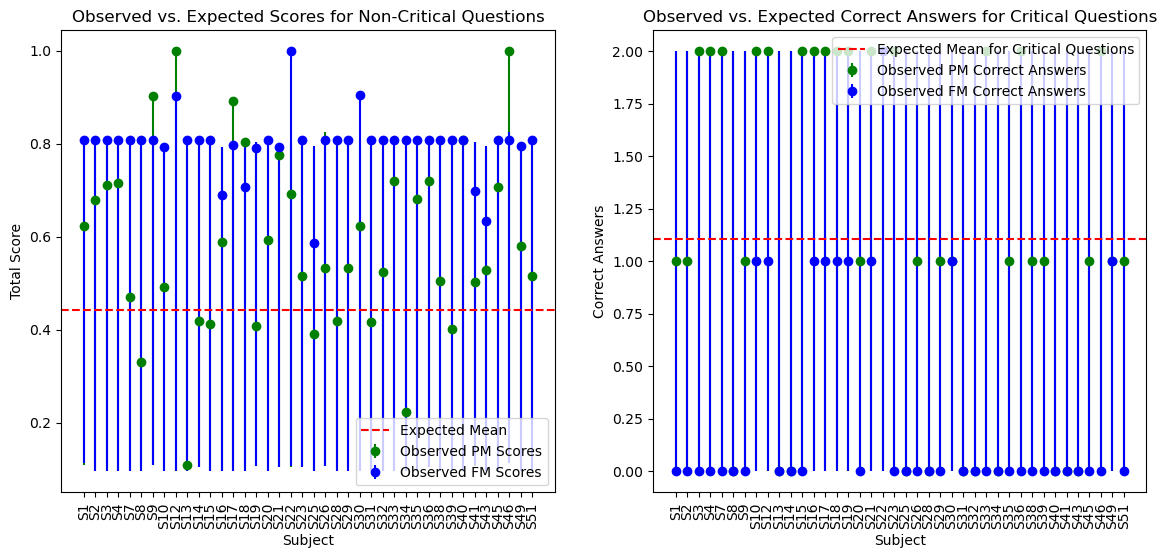

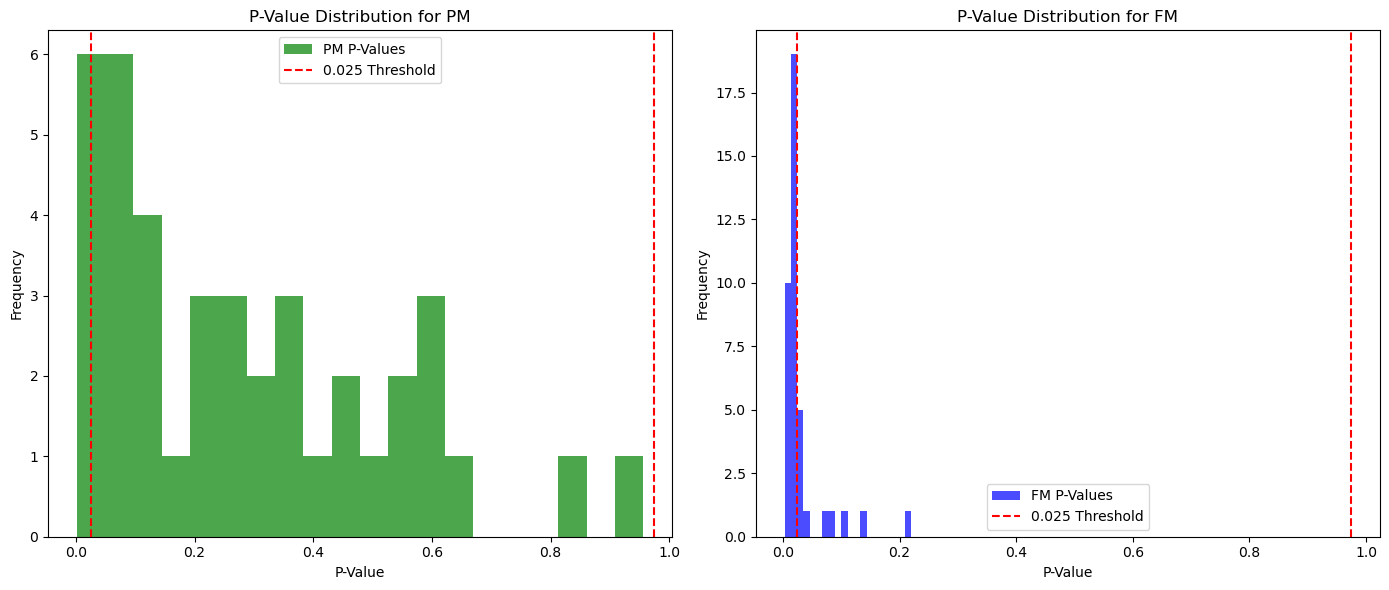

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities and observed scores for PM and FM
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Separate out the critical questions (Q3 and Q7)
    critical_indices = [2, 6]  # Q3 and Q7
    non_critical_indices = [i for i in range(8) if i not in critical_indices]

    # Observed correct answers for critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])

    # Observed total scores for non-critical questions
    observed_total_pm_non_critical = sum(obs_pm[non_critical_indices] * question_values[non_critical_indices])
    observed_total_fm_non_critical = sum(obs_fm[non_critical_indices] * question_values[non_critical_indices])

    # Simulate scores for PM and FM
    sim_totals_pm = []
    sim_totals_fm = []
    sim_correct_critical_pm = []
    sim_correct_critical_fm = []

    for _ in range(n_simulations):
        # Simulate preliminary responses
        sim_responses_pm = np.random.binomial(1, probs)
        sim_total_pm = np.dot(sim_responses_pm, question_values)
        sim_totals_pm.append(sim_total_pm)

        # For critical questions
        sim_correct_pm_critical = sum(sim_responses_pm[critical_indices])
        sim_correct_critical_pm.append(sim_correct_pm_critical)

        # Simulate final responses
        sim_responses_fm = np.random.binomial(1, probs)
        sim_total_fm = np.dot(sim_responses_fm, question_values)
        sim_totals_fm.append(sim_total_fm)

        # For critical questions
        sim_correct_fm_critical = sum(sim_responses_fm[critical_indices])
        sim_correct_critical_fm.append(sim_correct_fm_critical)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)

    # Calculate p-values
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm)

    p_value_pm_critical = np.mean(sim_correct_critical_pm >= observed_correct_pm_critical)
    p_value_fm_critical = np.mean(sim_correct_critical_fm >= observed_correct_fm_critical)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm = 1 if p_value_pm >= 0.025 and p_value_pm <= 0.975 else 0
    plausible_fm = 1 if p_value_fm >= 0.025 and p_value_fm <= 0.975 else 0
    plausible_pm_critical = 1 if p_value_pm_critical >= 0.025 and p_value_pm_critical <= 0.975 else 0
    plausible_fm_critical = 1 if p_value_fm_critical >= 0.025 and p_value_fm_critical <= 0.975 else 0

    # Calculate confidence intervals
    ci_lower_pm = np.percentile(sim_totals_pm, 2.5)
    ci_upper_pm = np.percentile(sim_totals_pm, 97.5)
    ci_lower_fm = np.percentile(sim_totals_fm, 2.5)
    ci_upper_fm = np.percentile(sim_totals_fm, 97.5)
    
    ci_lower_critical = np.percentile(sim_correct_critical_pm, 2.5)
    ci_upper_critical = np.percentile(sim_correct_critical_pm, 97.5)

    # Expected values
    expected_pm = np.mean(sim_totals_pm)
    expected_fm = np.mean(sim_totals_fm)
    expected_correct_critical = np.mean(sim_correct_critical_pm)

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected_PM': expected_pm,
        '95%_CI_Lower_PM': ci_lower_pm,
        '95%_CI_Upper_PM': ci_upper_pm,
        'Plausible_PM': plausible_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM': observed_total_fm,
        'Expected_FM': expected_fm,
        '95%_CI_Lower_FM': ci_lower_fm,
        '95%_CI_Upper_FM': ci_upper_fm,
        'Plausible_FM': plausible_fm,
        'P_Value_FM': p_value_fm,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'Expected_Correct_Critical': expected_correct_critical,
        '95% CI Lower_Critical': ci_lower_critical,
        '95% CI Upper_Critical': ci_upper_critical,
        'Plausible_PM_Critical': plausible_pm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'Plausible_FM_Critical': plausible_fm_critical,
        'P_Value_FM_Critical': p_value_fm_critical
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting functions
def plot_non_critical_questions(results_df):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)

    # Calculate non-negative yerr values
    yerr_pm = [
        np.maximum(0, results_df['Observed_Total_PM'] - results_df['95%_CI_Lower_PM']),
        np.maximum(0, results_df['95%_CI_Upper_PM'] - results_df['Observed_Total_PM'])
    ]
    yerr_fm = [
        np.maximum(0, results_df['Observed_Total_FM'] - results_df['95%_CI_Lower_FM']),
        np.maximum(0, results_df['95%_CI_Upper_FM'] - results_df['Observed_Total_FM'])
    ]

    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Total_PM'], 
                 yerr=yerr_pm, fmt='o', label='Observed PM Scores', color='green')
    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Total_FM'], 
                 yerr=yerr_fm, fmt='o', label='Observed FM Scores', color='blue')
    plt.axhline(y=results_df['Expected_PM'].mean(), color='red', linestyle='--', label='Expected Mean')
    plt.xticks(rotation=90)
    plt.xlabel('Subject')
    plt.ylabel('Total Score')
    plt.title('Observed vs. Expected Scores for Non-Critical Questions')
    plt.legend()

def plot_critical_questions(results_df):
    plt.subplot(1, 2, 2)

    # Calculate non-negative yerr values for critical questions
    yerr_pm_critical = [
        np.maximum(0, results_df['Observed_Correct_PM_Critical'] - results_df['95% CI Lower_Critical']),
        np.maximum(0, results_df['95% CI Upper_Critical'] - results_df['Observed_Correct_PM_Critical'])
    ]
    yerr_fm_critical = [
        np.maximum(0, results_df['Observed_Correct_FM_Critical'] - results_df['95% CI Lower_Critical']),
        np.maximum(0, results_df['95% CI Upper_Critical'] - results_df['Observed_Correct_FM_Critical'])
    ]

    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Correct_PM_Critical'],
                 yerr=yerr_pm_critical, fmt='o', label='Observed PM Correct Answers', color='green')
    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Correct_FM_Critical'],
                 yerr=yerr_fm_critical, fmt='o', label='Observed FM Correct Answers', color='blue')
    plt.axhline(y=results_df['Expected_Correct_Critical'].mean(), color='red', linestyle='--', label='Expected Mean for Critical Questions')
    plt.xticks(rotation=90)
    plt.xlabel('Subject')
    plt.ylabel('Correct Answers')
    plt.title('Observed vs. Expected Correct Answers for Critical Questions')
    plt.legend()

def plot_p_value_distributions(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    plt.hist(results_df['P_Value_PM'], bins=20, color='green', alpha=0.7, label='PM P-Values')
    plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.axvline(0.975, color='red', linestyle='--')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.title('P-Value Distribution for PM')
    plt.legend()
    
    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    plt.hist(results_df['P_Value_FM'], bins=20, color='blue', alpha=0.7, label='FM P-Values')
    plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.axvline(0.975, color='red', linestyle='--')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.title('P-Value Distribution for FM')
    plt.legend()

def visualize_results():
    plt.figure(figsize=(18, 8))
    
    # Plot for Non-Critical Questions
    plot_non_critical_questions(results_df)

    # Plot for Critical Questions
    plot_critical_questions(results_df)

    # Plot for P-Value Distributions
    plot_p_value_distributions(results_df)

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_results()


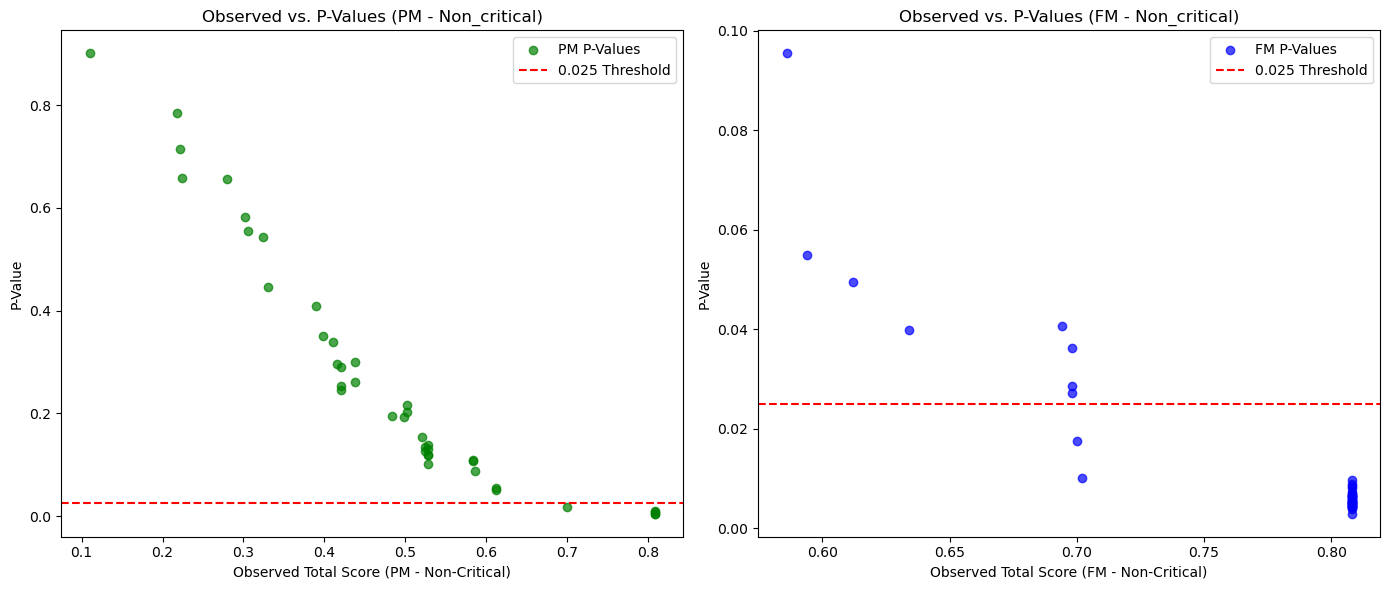

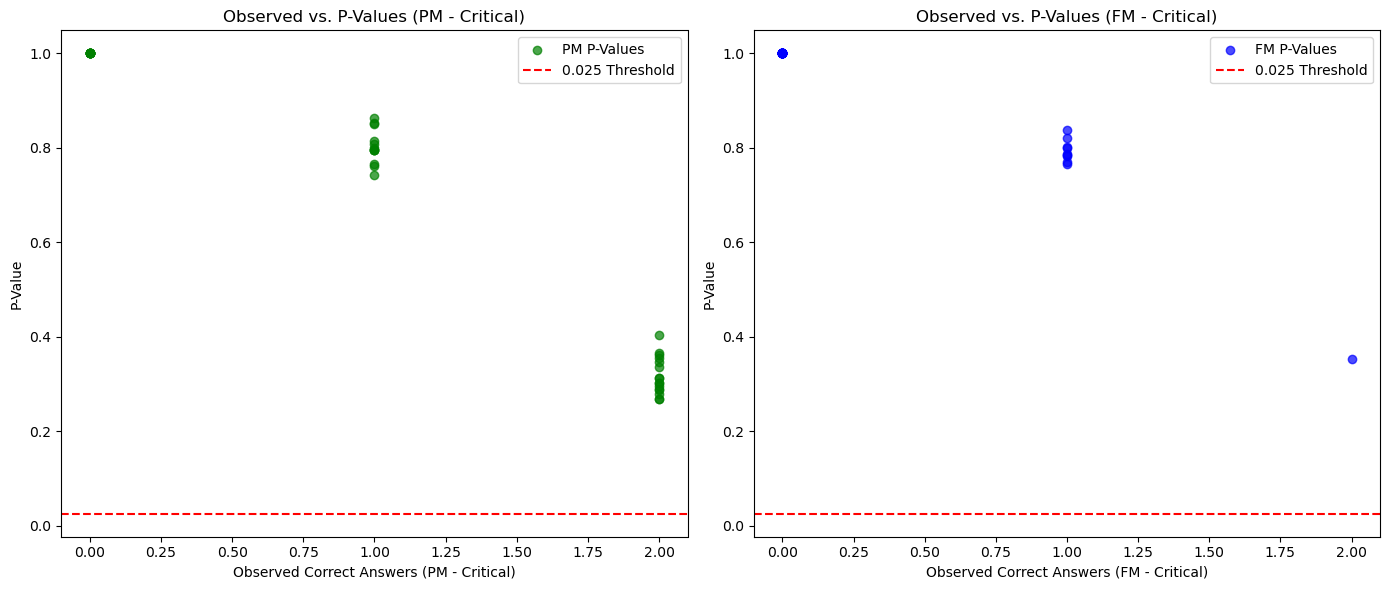

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Define question values and critical questions
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])
critical_indices = [2, 6]  # Q3 and Q7 (0-based indexing)
non_critical_indices = [i for i in range(8) if i not in critical_indices]


n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities and observed scores for PM and FM
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total scores for critical and non-critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])
    observed_total_pm_non_critical = np.dot(obs_pm[non_critical_indices], question_values[non_critical_indices])
    observed_total_fm_non_critical = np.dot(obs_fm[non_critical_indices], question_values[non_critical_indices])

    # Simulate scores for PM and FM
    sim_correct_critical_pm = []
    sim_correct_critical_fm = []
    sim_totals_pm_non_critical = []
    sim_totals_fm_non_critical = []

    for _ in range(n_simulations):
        # Simulate preliminary responses
        sim_responses_pm = np.random.binomial(1, probs)
        sim_correct_pm_critical = sum(sim_responses_pm[critical_indices])
        sim_correct_critical_pm.append(sim_correct_pm_critical)
        sim_total_pm_non_critical = np.dot(sim_responses_pm[non_critical_indices], question_values[non_critical_indices])
        sim_totals_pm_non_critical.append(sim_total_pm_non_critical)

        # Simulate final responses
        sim_responses_fm = np.random.binomial(1, probs)
        sim_correct_fm_critical = sum(sim_responses_fm[critical_indices])
        sim_correct_critical_fm.append(sim_correct_fm_critical)
        sim_total_fm_non_critical = np.dot(sim_responses_fm[non_critical_indices], question_values[non_critical_indices])
        sim_totals_fm_non_critical.append(sim_total_fm_non_critical)

    # Convert simulation results to numpy arrays
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)
    sim_totals_pm_non_critical = np.array(sim_totals_pm_non_critical)
    sim_totals_fm_non_critical = np.array(sim_totals_fm_non_critical)

    # Calculate p-values
    p_value_pm_critical = np.mean(sim_correct_critical_pm >= observed_correct_pm_critical)
    p_value_fm_critical = np.mean(sim_correct_critical_fm >= observed_correct_fm_critical)
    p_value_pm_non_critical = np.mean(sim_totals_pm_non_critical >= observed_total_pm_non_critical)
    p_value_fm_non_critical = np.mean(sim_totals_fm_non_critical >= observed_total_fm_non_critical)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm_critical = 1 if p_value_pm_critical >= 0.025 and p_value_pm_critical <= 0.975 else 0
    plausible_fm_critical = 1 if p_value_fm_critical >= 0.025 and p_value_fm_critical <= 0.975 else 0
    plausible_pm_non_critical = 1 if p_value_pm_non_critical >= 0.025 and p_value_pm_non_critical <= 0.975 else 0
    plausible_fm_non_critical = 1 if p_value_fm_non_critical >= 0.025 and p_value_fm_non_critical <= 0.975 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'Plausible_PM_Critical': plausible_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'P_Value_FM_Critical': p_value_fm_critical,
        'Plausible_FM_Critical': plausible_fm_critical,
        'Observed_Total_PM_Non_Critical': observed_total_pm_non_critical,
        'P_Value_PM_Non_Critical': p_value_pm_non_critical,
        'Plausible_PM_Non_Critical': plausible_pm_non_critical,
        'Observed_Total_FM_Non_Critical': observed_total_fm_non_critical,
        'P_Value_FM_Non_Critical': p_value_fm_non_critical,
        'Plausible_FM_Non_Critical': plausible_fm_non_critical
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


def plot_pvalues(results_df, question_type):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (PM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (PM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (PM - {question_type.capitalize()})')
    plt.legend()

    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (FM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (FM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (FM - {question_type.capitalize()})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_critical_non_critical_results():
    # Plot for Non-Critical Questions
    plot_pvalues(results_df, 'non_critical')

    # Plot for Critical Questions
    plot_pvalues(results_df, 'critical')

# Call the visualization function
visualize_critical_non_critical_results()




KeyError: 'Observed_Total_PM_Non_Critical'

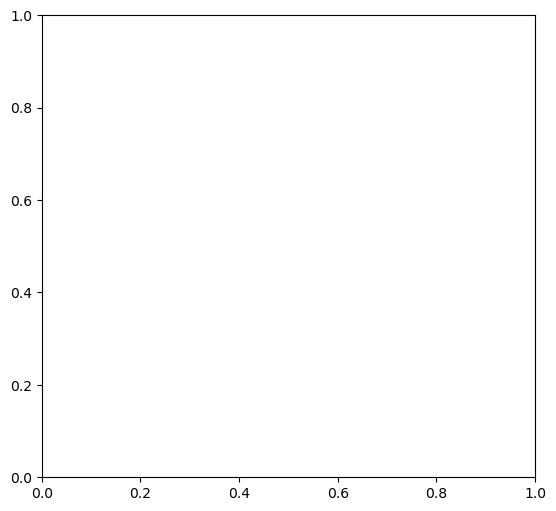

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot for Non-Critical Questions
def plot_non_critical_pvalues(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values of Non-Critical Questions
    plt.subplot(1, 2, 1)
    plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                color='green', label='PM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Total Score (PM - Non-Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Total Scores vs. P-Values (PM - Non-Critical)')
    plt.legend()
    
    # Plot for FM P-Values of Non-Critical Questions
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                color='blue', label='FM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Total Score (FM - Non-Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Total Scores vs. P-Values (FM - Non-Critical)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for Critical Questions
def plot_critical_pvalues(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values of Critical Questions
    plt.subplot(1, 2, 1)
    plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                color='green', label='PM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Correct Answers (PM - Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Correct Answers vs. P-Values (PM - Critical)')
    plt.legend()
    
    # Plot for FM P-Values of Critical Questions
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                color='blue', label='FM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Correct Answers (FM - Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Correct Answers vs. P-Values (FM - Critical)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
def visualize_critical_non_critical_results():
    # Plot for Non-Critical Questions
    plot_non_critical_pvalues(results_df)
    
    # Plot for Critical Questions
    plot_critical_pvalues(results_df)
    
# Call the visualization function
visualize_critical_non_critical_results()


# _____________________________________________________
 
# Complementary analyses 
## _____________________________________________________


# Plausibility of Results  (Separately)

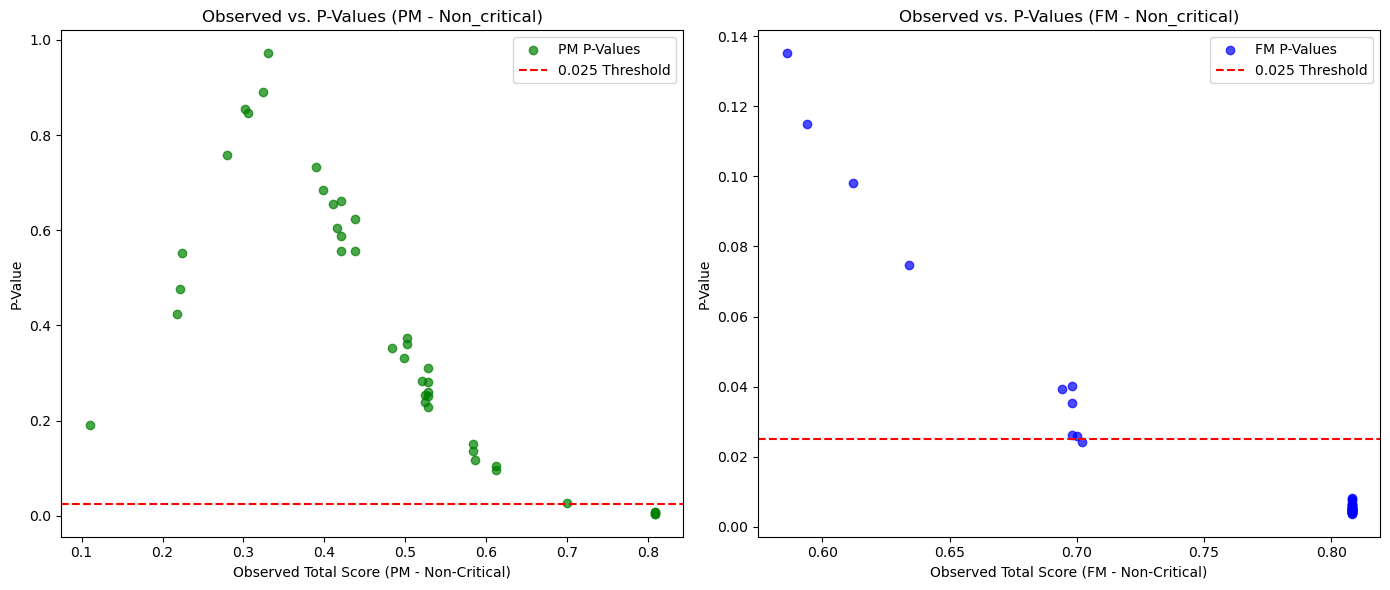

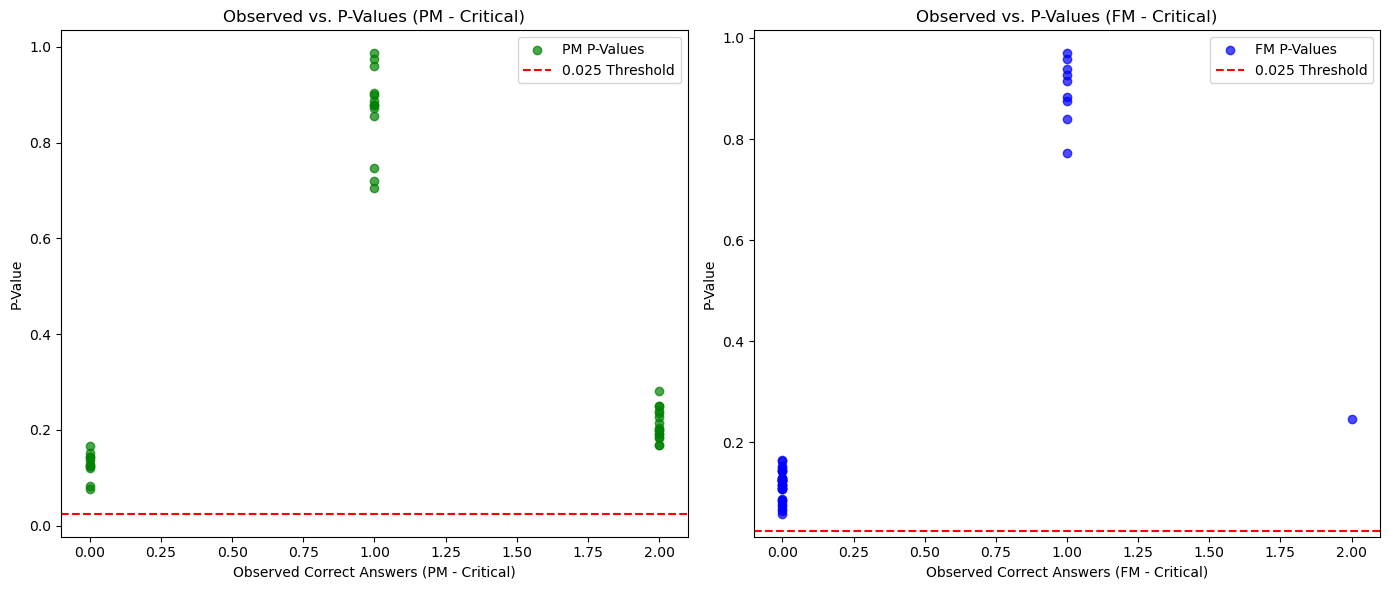

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Step 2: Define the Monte Carlo Simulation for Each Student
n_simulations = 10000
results = []

# Indices of critical and non-critical questions
critical_indices = [2, 6]  # Q3 and Q7
non_critical_indices = [i for i in range(8) if i not in critical_indices]
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Simulate results for each student
for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Observed correct answers for critical and non-critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])
    observed_total_pm_non_critical = sum(obs_pm[non_critical_indices] * question_values[non_critical_indices])
    observed_total_fm_non_critical = sum(obs_fm[non_critical_indices] * question_values[non_critical_indices])

    # Simulate scores
    sim_totals_pm, sim_totals_fm, sim_correct_critical_pm, sim_correct_critical_fm = [], [], [], []

    for _ in range(n_simulations):
        sim_responses_pm = np.random.binomial(1, probs)
        sim_responses_fm = np.random.binomial(1, probs)
        sim_totals_pm.append(np.dot(sim_responses_pm[non_critical_indices], question_values[non_critical_indices]))
        sim_totals_fm.append(np.dot(sim_responses_fm[non_critical_indices], question_values[non_critical_indices]))
        sim_correct_critical_pm.append(sum(sim_responses_pm[critical_indices]))
        sim_correct_critical_fm.append(sum(sim_responses_fm[critical_indices]))

    # Convert to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)

    # Calculate mean and standard deviation for normal approximation
    mean_pm_non_critical = np.mean(sim_totals_pm)
    std_pm_non_critical = np.std(sim_totals_pm)
    mean_fm_non_critical = np.mean(sim_totals_fm)
    std_fm_non_critical = np.std(sim_totals_fm)

    mean_pm_critical = np.mean(sim_correct_critical_pm)
    std_pm_critical = np.std(sim_correct_critical_pm)
    mean_fm_critical = np.mean(sim_correct_critical_fm)
    std_fm_critical = np.std(sim_correct_critical_fm)

    # Calculate z-scores for the observed values
    z_score_pm_non_critical = (observed_total_pm_non_critical - mean_pm_non_critical) / std_pm_non_critical
    z_score_fm_non_critical = (observed_total_fm_non_critical - mean_fm_non_critical) / std_fm_non_critical

    z_score_pm_critical = (observed_correct_pm_critical - mean_pm_critical) / std_pm_critical
    z_score_fm_critical = (observed_correct_fm_critical - mean_fm_critical) / std_fm_critical

    # Calculate p-values from z-scores
    p_value_pm_non_critical = 2 * (1 - norm.cdf(abs(z_score_pm_non_critical)))
    p_value_fm_non_critical = 2 * (1 - norm.cdf(abs(z_score_fm_non_critical)))

    p_value_pm_critical = 2 * (1 - norm.cdf(abs(z_score_pm_critical)))
    p_value_fm_critical = 2 * (1 - norm.cdf(abs(z_score_fm_critical)))

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM_Non_Critical': observed_total_pm_non_critical,
        'Observed_Total_FM_Non_Critical': observed_total_fm_non_critical,
        'Z_Score_PM_Non_Critical': z_score_pm_non_critical,
        'Z_Score_FM_Non_Critical': z_score_fm_non_critical,
        'P_Value_PM_Non_Critical': p_value_pm_non_critical,
        'P_Value_FM_Non_Critical': p_value_fm_non_critical,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'Z_Score_PM_Critical': z_score_pm_critical,
        'Z_Score_FM_Critical': z_score_fm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'P_Value_FM_Critical': p_value_fm_critical
    })

results_df = pd.DataFrame(results)

# Step 4: Visualize the Results
def plot_p_values(results_df, question_type):
    plt.figure(figsize=(14, 6))

    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (PM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (PM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (PM - {question_type.capitalize()})')
    plt.legend()

    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (FM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (FM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (FM - {question_type.capitalize()})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 5: Visualize Results for Both Non-Critical and Critical Questions
def visualize_results():
    # Plot for Non-Critical Questions
    plot_p_values(results_df, 'non_critical')

    # Plot for Critical Questions
    plot_p_values(results_df, 'critical')

# Call the visualization function
visualize_results()
